# Jie Shen Testing 2.0

Here we will try YOLO/YOLO-obb to draw some bounding boxes (Predicted vs Ground Truth)

Dependencies
```
%pip install torch torchvision torchaudio
%pip install opencv-python ultralytics
```

In [1]:
from datetime import datetime
from IPython.display import display, Markdown

display(Markdown(f'**Last Updated**: {datetime.now().isoformat()}'))

**Last Updated**: 2025-03-08T23:05:31.701089

In [2]:
%pip install -U pip wheel
%pip install dotenv

%pip install torch torchvision torchaudio
%pip install opencv-python ultralytics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [3]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()

sys.path.append(os.path.join(os.getenv('PROJECT_ROOT'), os.getenv('SRC_DIR')))

data_dir = os.path.join(os.getenv('PROJECT_ROOT'), os.getenv('DATA_DIR'))
model_dir = os.path.join(os.getenv('PROJECT_ROOT'), os.getenv('MODEL_DIR'))

## 1.0 Basic Data Understanding

### 1.1 Class Label Distribution

Here we check first the number of instances in each label class

In [4]:
def read_ground_truth(path: str):
    with open(path, 'r') as f:
        cls_xywhn = []

        for line in f:
            values = line.strip().split(' ')

            cls = int(values[0])

            x, y, w, h = map(float, values[1:])

            cls_xywhn.append((cls, x, y, w, h))

        return cls_xywhn
    
def xywhn_to_xyxy(image, x, y, w, h):
    # cv2 images in HWC
    height, width, _ = image.shape

    x1 = int((x - w / 2) * width)
    y1 = int((y - h / 2) * height)
    x2 = int((x + w / 2) * width)
    y2 = int((y + h / 2) * height)

    return x1, y1, x2, y2

In [5]:
import pandas as pd

train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

classes = []

for filename in os.listdir(train_labels_dir):
    cls_xywhn = read_ground_truth(os.path.join(train_labels_dir, filename))

    cls = [cls for cls, _, _, _, _ in cls_xywhn]

    classes += cls

df_classes = pd.DataFrame(classes, columns=['Class'])

df_classes

Class
0          1
1          0
2          0
3          0
4          0
...      ...
10229      0
10230      0
10231      2
10232      1
10233      0

[10234 rows x 1 columns]

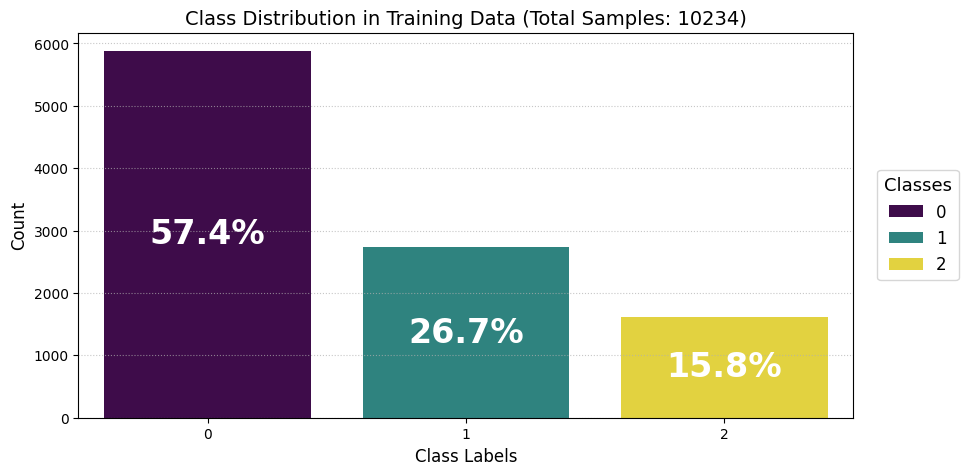

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

total_counts = len(df_classes['Class'])

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Class', data=df_classes, palette='viridis', hue='Class')

for p in ax.patches:
    # Get the height of the bar
    count = p.get_height()
    # Skip for zero counts
    if count > 0:
        # Calculate percentage
        percentage = f'{count / total_counts * 100:.1f}%' 
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() / 2, percentage, 
                ha='center', va='center', fontsize=24, color='white', fontweight='bold')
    
ax.grid(axis='y', linestyle=':', alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Classes', fontsize=12, title_fontsize=13, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Class Distribution in Training Data (Total Samples: {total_counts})', fontsize=14)

plt.show()

### 1.2 Sample Image Visualisation

Here we try to visualise a sample image, in order to figure out what the class label means

In [7]:
def get_filename_containing_classes(classes: set, labels_dir: str) -> str:
    for filename in os.listdir(labels_dir):
        cls_xywhn = read_ground_truth(os.path.join(labels_dir, filename))

        cls = [cls for cls, *_ in cls_xywhn]

        if set(cls) == classes:
            return filename.split('.')[0]

    return None

In [108]:
import cv2
from itertools import combinations

classes = df_classes['Class'].unique().tolist()

train_img_dir = os.path.join(data_dir, os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

comb_imgs = []

for comb in [set(comb) for r in range(len([0, 1, 2]) + 1) for comb in combinations([0, 1, 2], r)]:
    sample_filename = get_filename_containing_classes(comb, train_labels_dir)

    if sample_filename is None:
        print(f'No sample found for classes: {comb}')
        continue

    sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
    cls_xywhns = read_ground_truth(os.path.join(train_labels_dir, f'{sample_filename}.txt'))

    for cls, *xywhn in cls_xywhns:
        xyxy = xywhn_to_xyxy(sample_img, *xywhn)
        cv2.rectangle(sample_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 5)
        cv2.putText(sample_img, f'Class: {str(cls)}', (xyxy[0], xyxy[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)

    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    comb_imgs.append((comb, sample_img))

No sample found for classes: set()


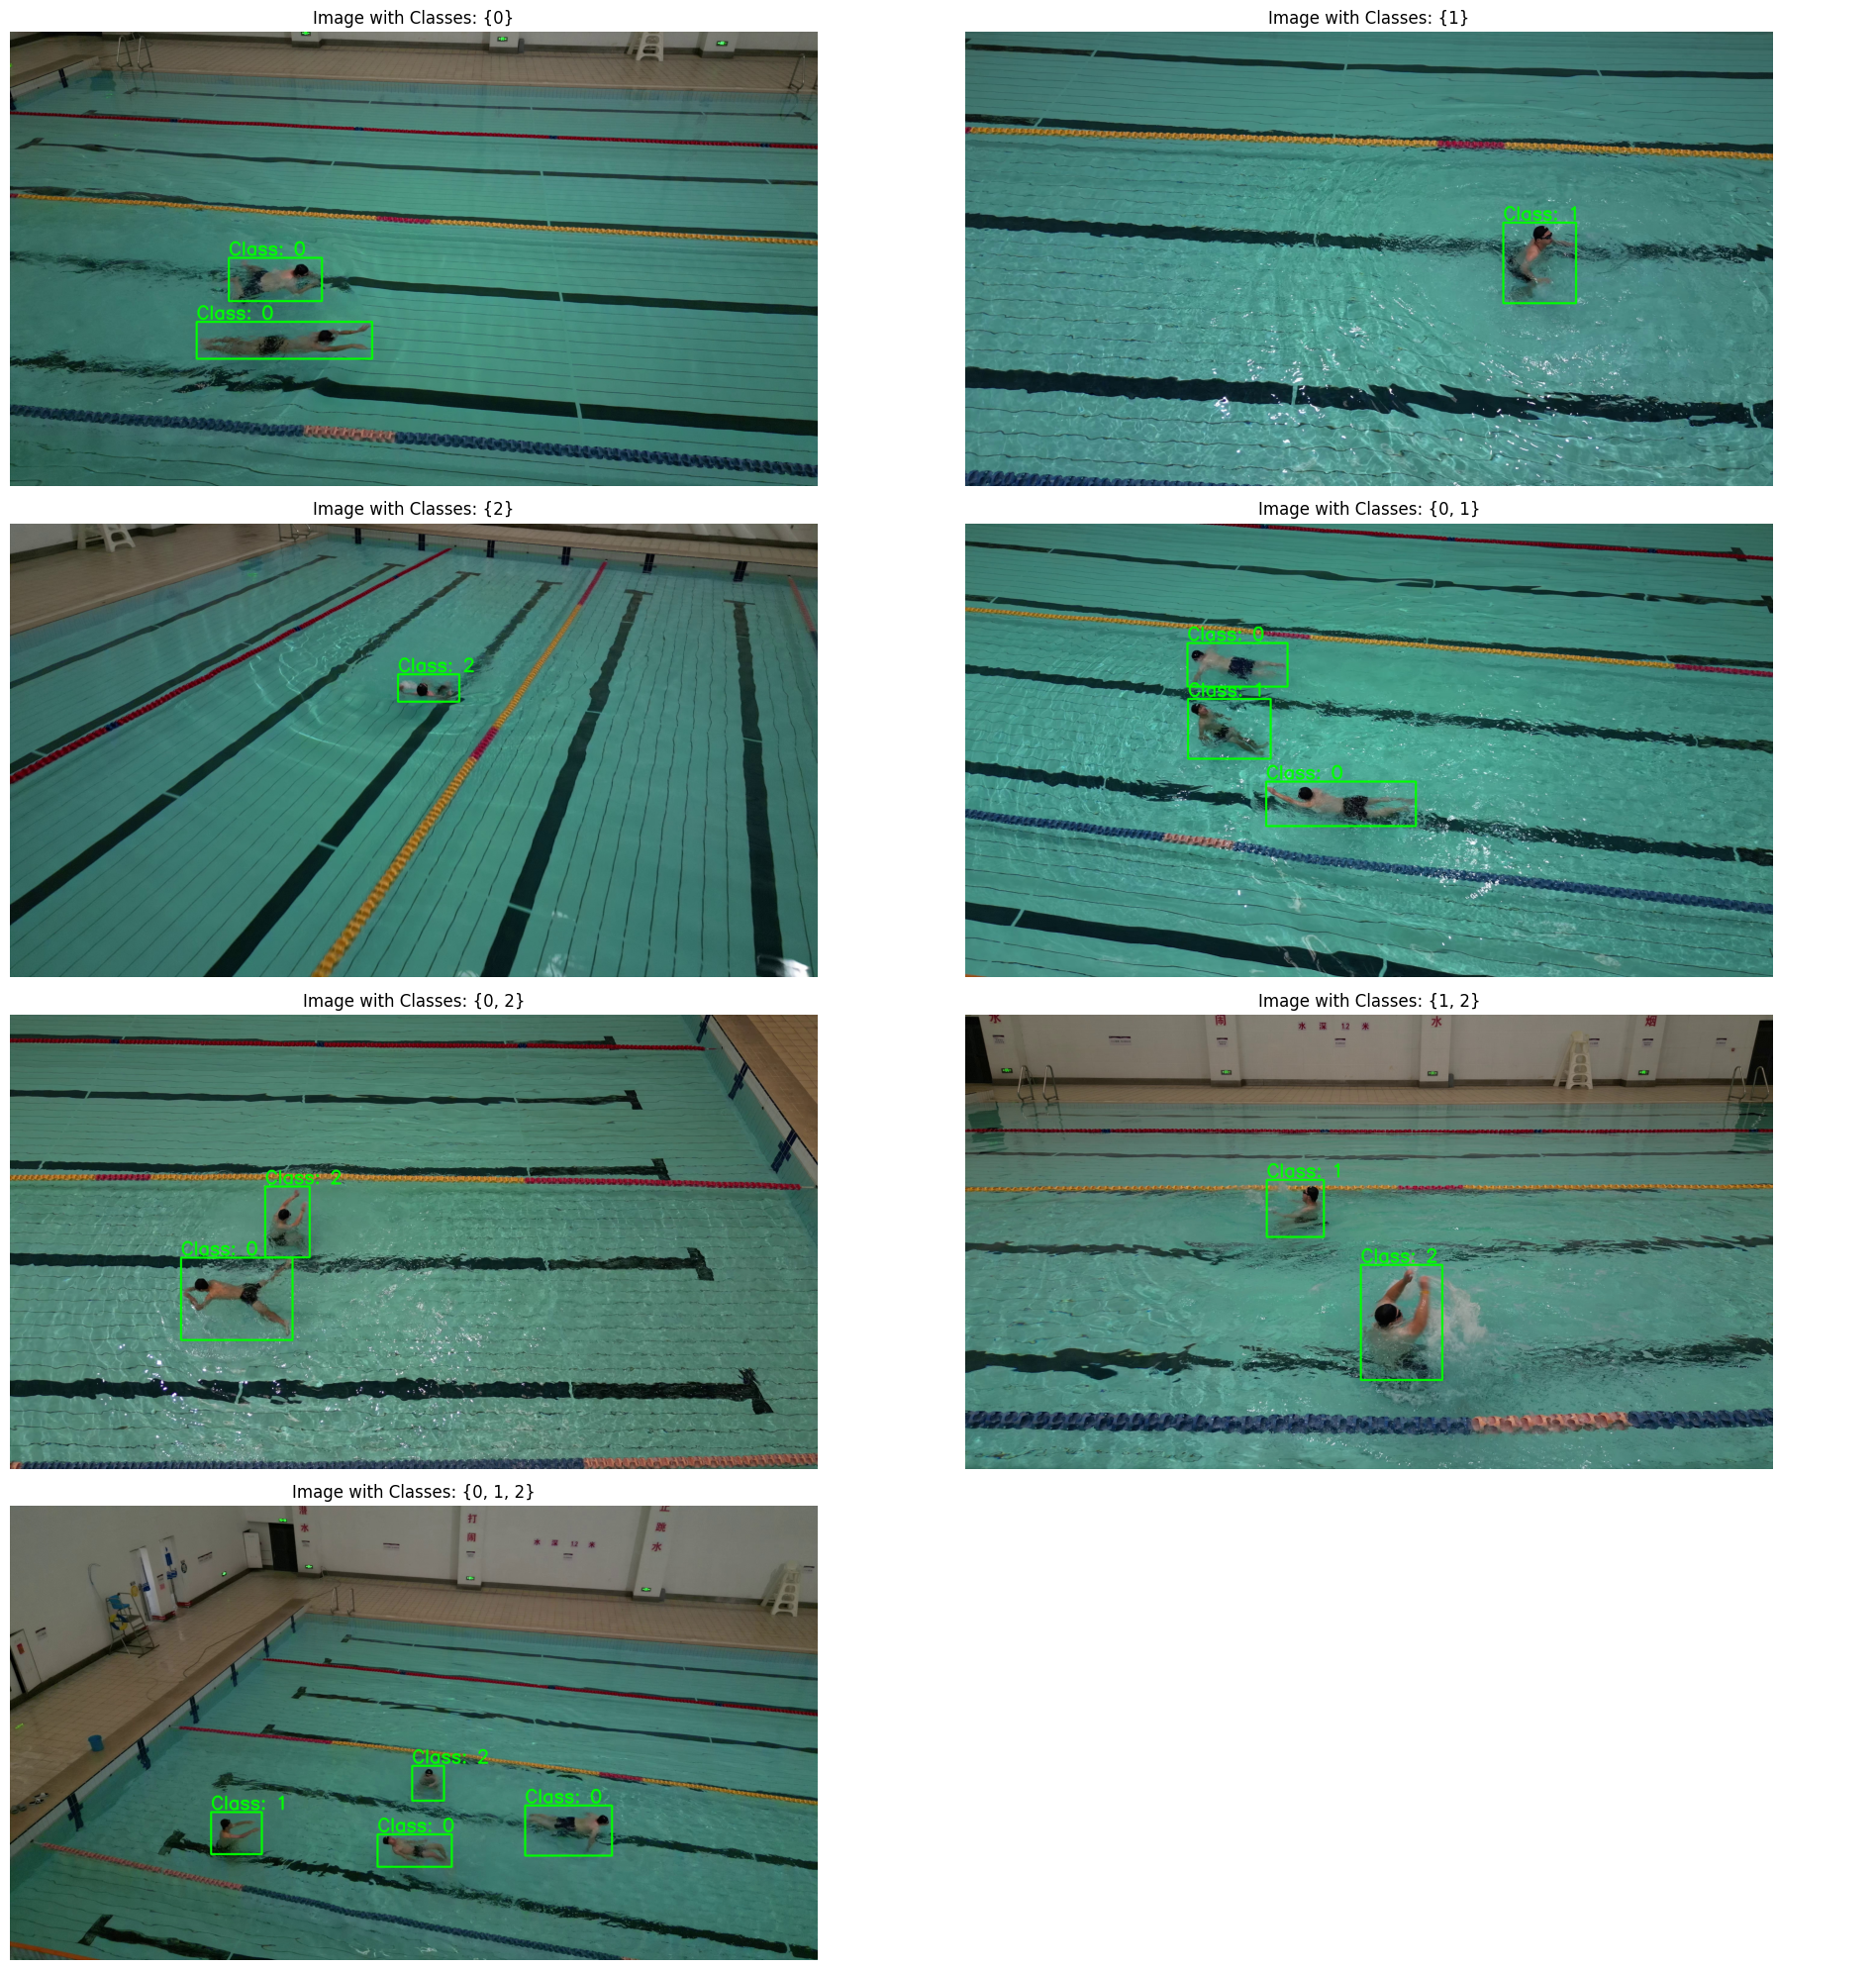

In [31]:
import matplotlib.pyplot as plt

num_imgs = len(comb_imgs)
num_cols = 2
num_rows = (num_imgs // num_cols) + (num_imgs % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

axes = axes.flatten()

for i, (comb, img) in enumerate(comb_imgs):
    axes[i].imshow(img)
    axes[i].set_title(f'Image with Classes: {comb}', fontsize=12)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 1.2 Sample Images for Classes

Here we display some sample cropped images for each class

Therefore, we can conclude that:
- 0 corresponds to **swimming**
- 1 corresponds to **tread water**
- 2 corresponds to **drowning**

In [28]:
import cv2

classes = df_classes['Class'].unique().tolist()

train_img_dir = os.path.join(data_dir, os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

cls_imgs = []

for cls in [set([cls]) for cls in classes]:
    sample_filename = get_filename_containing_classes(cls, train_labels_dir)

    if sample_filename is None:
        print(f'No sample found for classes: {cls}')
        continue

    sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
    cls_xywhn = read_ground_truth(os.path.join(train_labels_dir, f'{sample_filename}.txt'))[0]

    cls, *xywhn = cls_xywhn
    xyxy = xywhn_to_xyxy(sample_img, *xywhn)

    sample_img = sample_img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]

    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    cls_imgs.append((cls, sample_img))

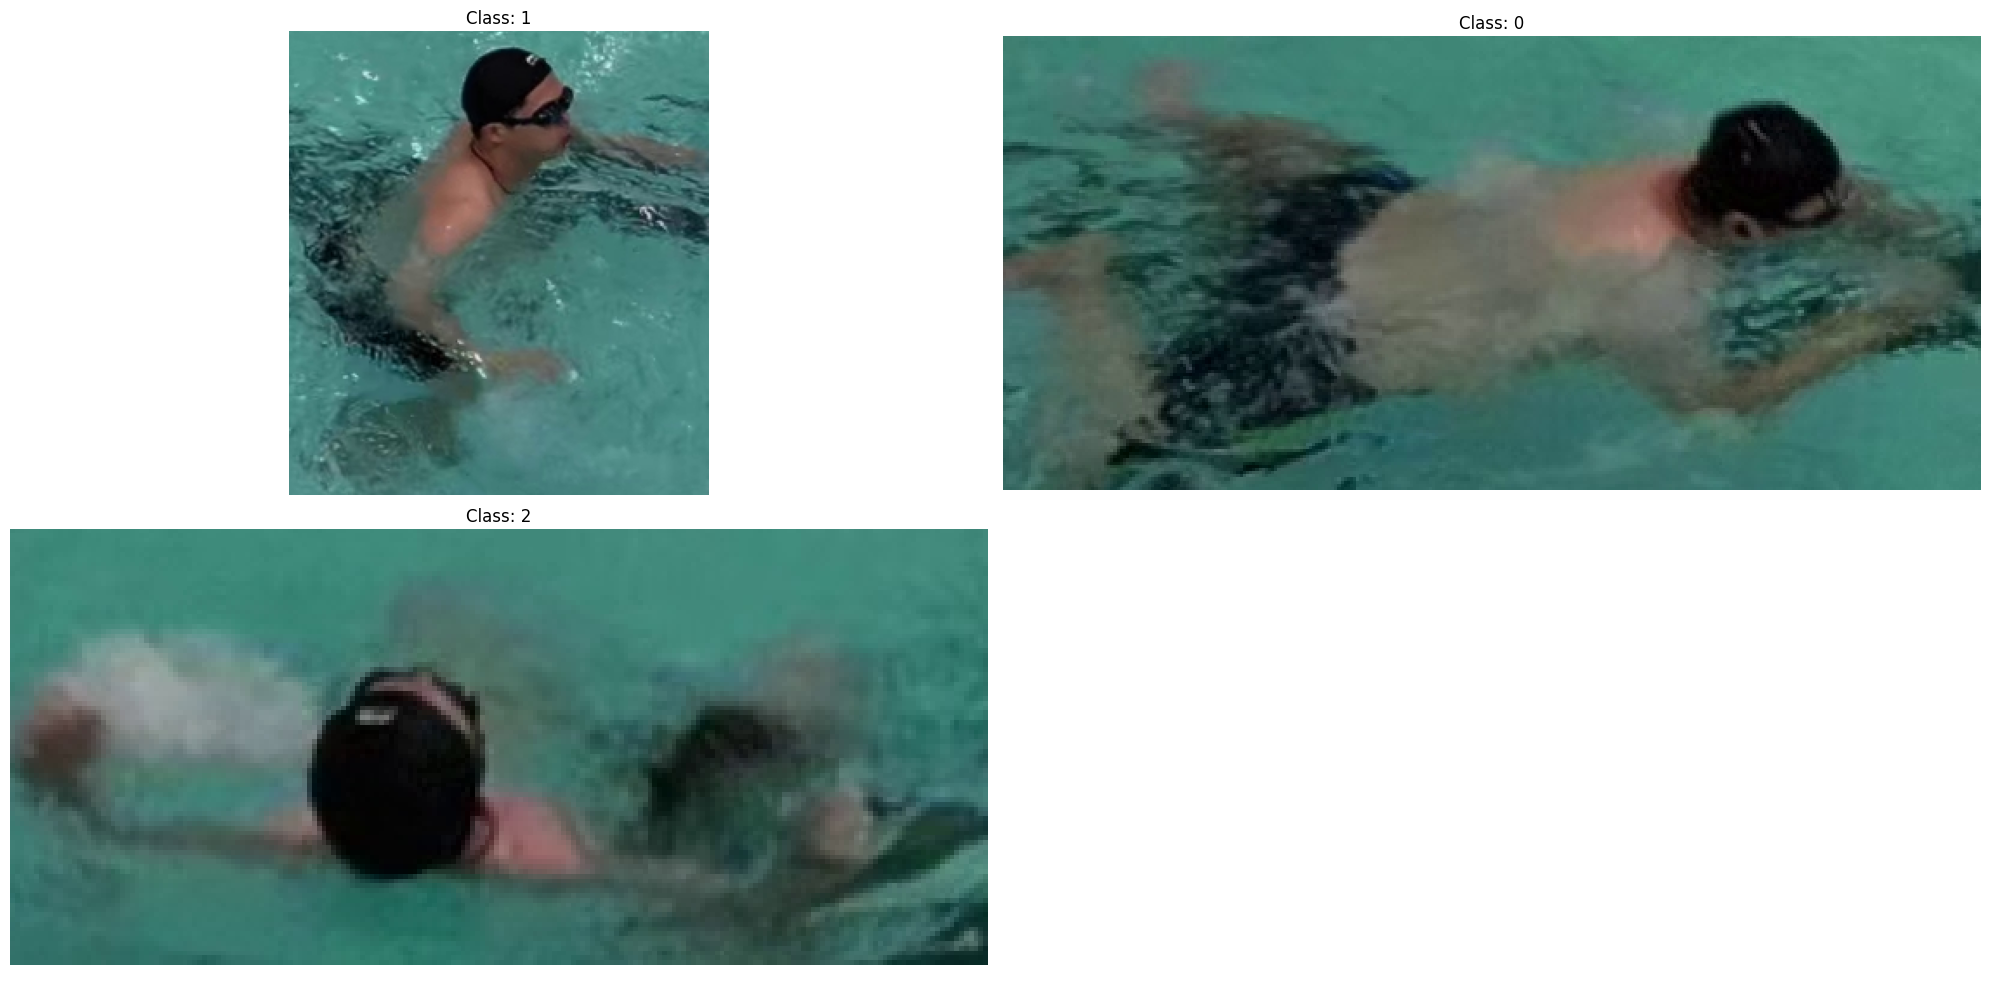

In [29]:
import matplotlib.pyplot as plt

num_imgs = len(cls_imgs)
num_cols = 2
num_rows = (num_imgs // num_cols) + (num_imgs % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

axes = axes.flatten()

for i, (cls, img) in enumerate(cls_imgs):
    axes[i].imshow(img)
    axes[i].set_title(f'Class: {cls}', fontsize=12)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 1.3 Visualising Different Channels of Images

Here we visualise different channels of an image seperately, to understand the contribution of each channel to the orignal image

In [109]:
import cv2
import re

train_img_dir = os.path.join(data_dir, os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

sample_filename = '000434'

sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

format_imgs = []

for color_space in ['RGB', 'HSV', 'YCbCr']:
    cv_convert = cv2.COLOR_BGR2RGB if color_space == 'RGB' else cv2.COLOR_BGR2HSV if color_space == 'HSV' else cv2.COLOR_BGR2YCrCb if color_space == 'YCbCr' else None
    
    if color_space == 'RGB':
        transformed_img = sample_img
    else:
        transformed_img = cv2.cvtColor(sample_img, cv_convert)

    channels =  re.findall(r'[A-Z][a-z]*', color_space)

    format_imgs.append((color_space, channels, sample_img, transformed_img))

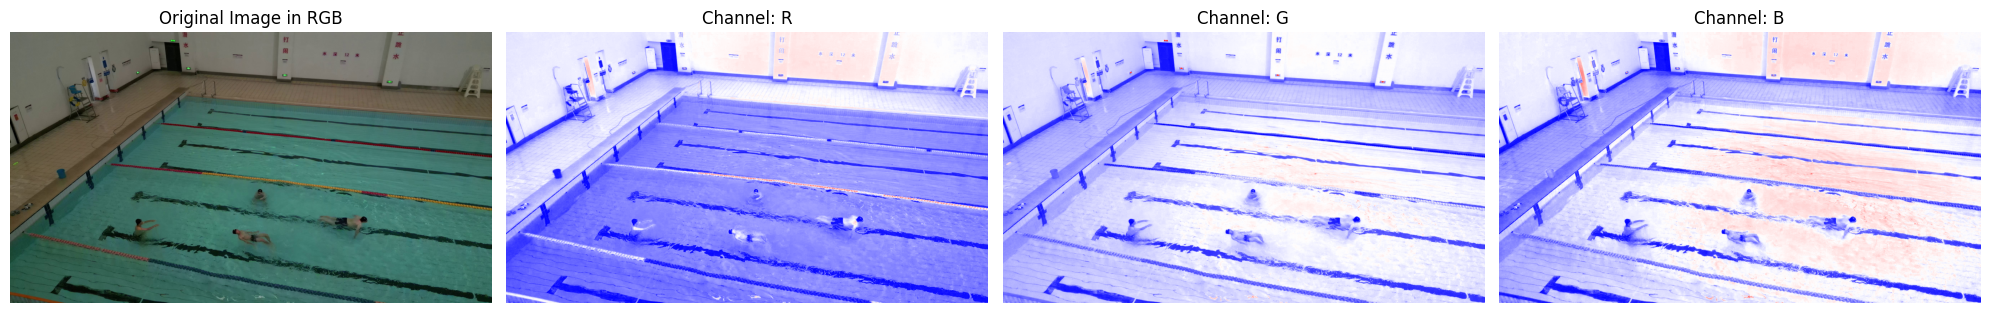

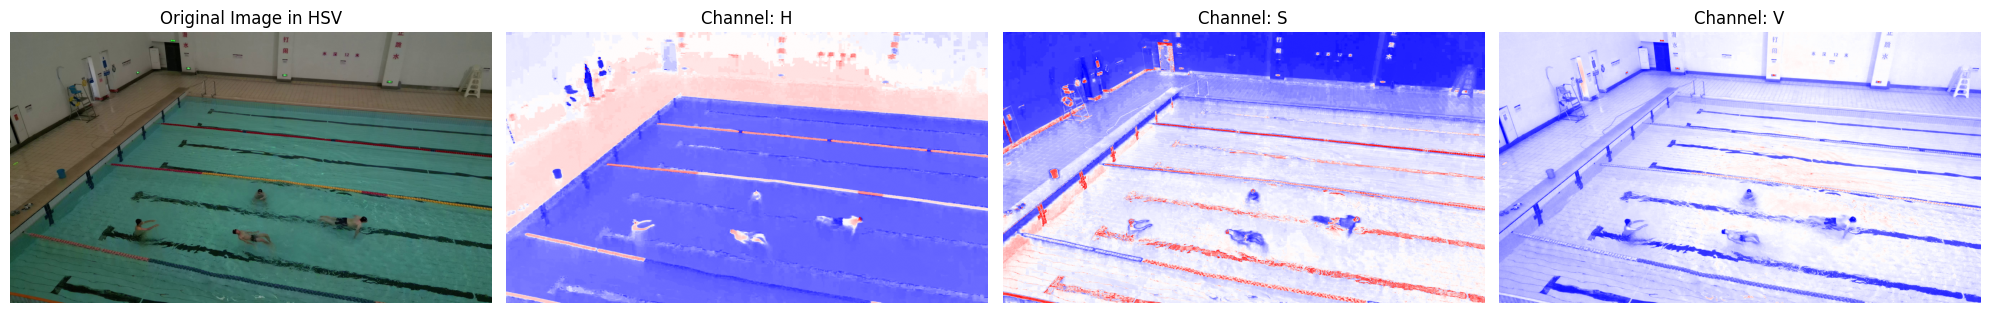

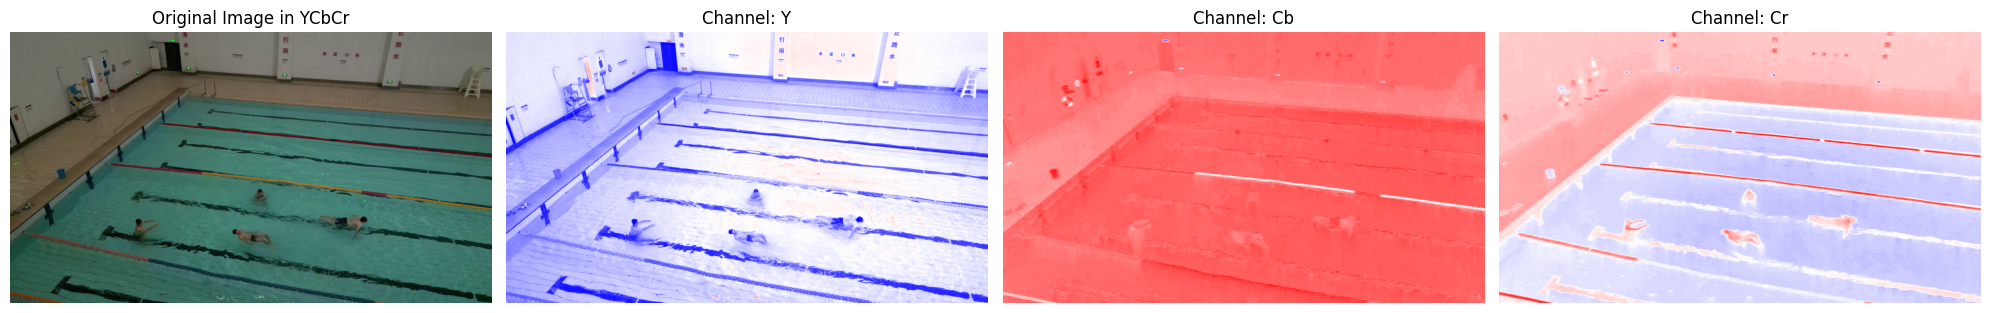

In [110]:
import matplotlib.pyplot as plt

for color_space, channels, orignal_img, transformed_img in format_imgs:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes = axes.flatten()

    axes[0].imshow(orignal_img)
    axes[0].set_title(f'Original Image in {color_space}', fontsize=12)
    axes[0].axis('off')

    for i, channel in enumerate(channels):
        axes[i + 1].imshow(transformed_img[:, :, i], cmap='bwr')
        axes[i + 1].set_title(f'Channel: {channel}', fontsize=12)
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

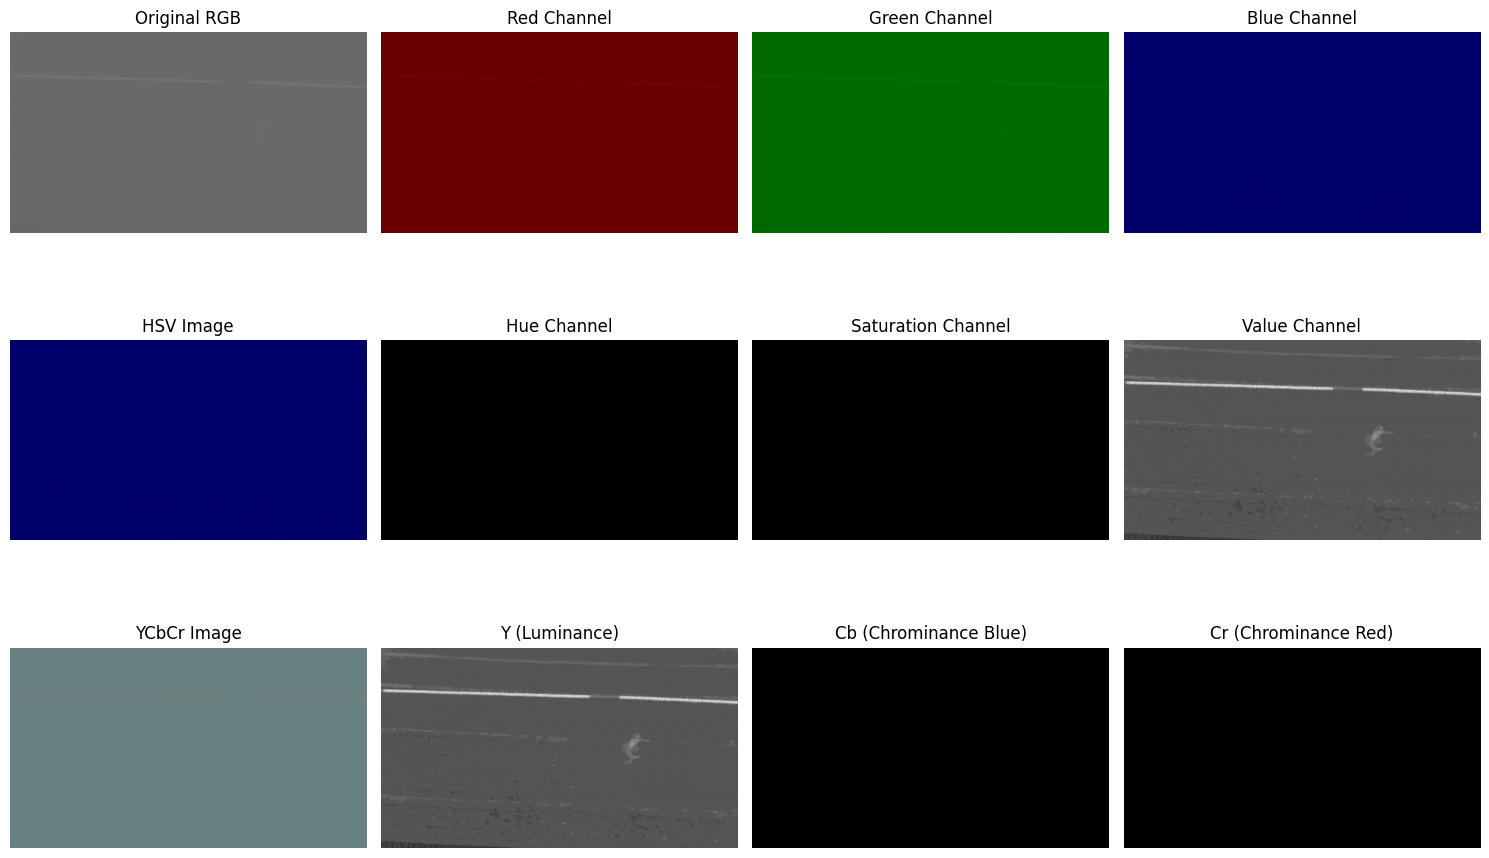

In [72]:
sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (OpenCV loads as BGR)

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image and convert from BGR to RGB

# Convert to different color spaces
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

# Split channels
r, g, b = cv2.split(img)
h, s, v = cv2.split(hsv)
y, cb, cr = cv2.split(ycbcr)

# Function to create a single-channel color image
def create_color_channel(channel, color):
    blank = np.zeros_like(channel)  
    if color == 'red':
        return np.stack([channel, blank, blank], axis=2)  # Red only
    elif color == 'green':
        return np.stack([blank, channel, blank], axis=2)  # Green only
    elif color == 'blue':
        return np.stack([blank, blank, channel], axis=2)  # Blue only

# Create color-channel images
red_img = create_color_channel(r, 'red')
green_img = create_color_channel(g, 'green')
blue_img = create_color_channel(b, 'blue')

# Titles for each subplot
titles = ['Original RGB', 'Red Channel', 'Green Channel', 'Blue Channel',
          'HSV Image', 'Hue Channel', 'Saturation Channel', 'Value Channel',
          'YCbCr Image', 'Y (Luminance)', 'Cb (Chrominance Blue)', 'Cr (Chrominance Red)']

# Images to display
images = [img, red_img, green_img, blue_img, 
          hsv, h, s, v, 
          ycbcr, y, cb, cr]

# Create subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Display images
for ax, img, title in zip(axes.flat, images, titles):
    if len(img.shape) == 2:  
        ax.imshow(img, cmap='gray')  # Use grayscale colormap for intensity-based channels
    else:  
        ax.imshow(img)  # Display RGB normally
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()



## 2.0 Human Detection

Now here we use different variants of YOLO for human detection

In [40]:
import cv2

train_img_dir = os.path.join(data_dir, os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

sample_filename = '000000'

sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
sample_img = cv2.resize(sample_img, (sample_img.shape[1] // 2, sample_img.shape[0] // 2), interpolation=cv2.INTER_AREA)

test_cls, xywhn = read_ground_truth(os.path.join(train_labels_dir, f'{sample_filename}.txt'))
xyxy = xywhn_to_xyxy(sample_img, *xywhn)

cv2.rectangle(sample_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
cv2.putText(sample_img, f'Class: {str(test_cls)}', (xyxy[0], xyxy[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

cv2.imshow('Sample Image', sample_img)

cv2.waitKey(0)

cv2.destroyAllWindows()

In [3]:
from ultralytics import YOLO
import cv2
import torch

yolo_dir = os.path.join(os.getenv('PROJECT_ROOT'), 'models', 'YOLO')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

yolov11n = YOLO(os.path.join(yolo_dir, 'yolo11n.pt'))

yolov11n = yolov11n.to(device)

yolov11n

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [12]:
train_img_dir = os.path.join(os.getenv('PROJECT_ROOT'), 'data', 'images', 'train')
train_truth_dir = os.path.join(os.getenv('PROJECT_ROOT'), 'data', 'labels', 'train')

test_img = cv2.imread(os.path.join(train_img_dir, '000000.jpg'))
test_img = cv2.resize(test_img, (test_img.shape[1] // 2, test_img.shape[0] // 2), interpolation=cv2.INTER_AREA)

test_cls, xywhn = read_ground_truth(os.path.join(train_truth_dir, '000000.txt'))
xyxy = xywhn_to_xyxy(test_img, *xywhn)

cv2.rectangle(test_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
cv2.putText(test_img, f'Class: {str(test_cls)}', (xyxy[0], xyxy[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

cv2.imshow('test_img', test_img)

cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:
import pandas as pd

def build_filenames(range_start: int, range_end: int, extension: str = 'txt') -> list:
    return [
        f'{str(i).zfill(6)}.{extension}'
        for i in range(range_start, range_end + 1)
    ]

classes = []

for filename in os.listdir(train_truth_dir):
    with open(os.path.join(train_truth_dir, filename), 'r') as f:
        for line in f:
            cls = int(line.strip().split(' ')[0])

            classes.append(cls)

series = pd.Series(classes, name='Class')

series

0        1
1        0
2        0
3        0
4        0
        ..
10229    0
10230    0
10231    2
10232    1
10233    0
Name: Class, Length: 10234, dtype: int64

In [ ]:
series.value_counts().sort_index()

Class
0    5878
1    2734
2    1622
Name: count, dtype: int64

In [5]:
CLASS_HUMAN = 0

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break


    # Run YOLO inference
    results = yolov11n(frame)

    # print(results)

    # print(results[0].boxes)

    # print(results[0].boxes[0])

    # break

    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls = int(box.cls[0].item())
            conf = box.conf[0].item()
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            if True or cls == CLASS_HUMAN and conf > 0.5:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"Human {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show frame
    cv2.imshow('Webcam Human Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


0: 480x640 (no detections), 292.5ms
Speed: 7.3ms preprocess, 292.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 261.3ms
Speed: 5.9ms preprocess, 261.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 269.4ms
Speed: 4.3ms preprocess, 269.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 245.9ms
Speed: 4.9ms preprocess, 245.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 231.9ms
Speed: 4.0ms preprocess, 231.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 234.2ms
Speed: 3.3ms preprocess, 234.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 237.1ms
Speed: 5.8ms preprocess, 237.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 234.3ms
Speed: 4.9ms prepr